In [1]:
'''
Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning
Dataset : https://data.mendeley.com/datasets/rscbjbr9sj/2
By Thomas Sabatier
'''

'\nIdentifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning\nDataset : https://data.mendeley.com/datasets/rscbjbr9sj/2\nBy Thomas Sabatier\n'

In [2]:
# Librairies

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import image_dataset_from_directory


In [3]:
# Pre-processing


data_path = './data/chest_xray/'
batch_size = 32
img_height = 128
img_width = 128

# Build datasets with 32 batches and shuffle
train_data = image_dataset_from_directory(
    directory=data_path+'train',
    validation_split=0.2,
    subset='training',
    batch_size=batch_size, 
    image_size=(img_height, img_width), 
    shuffle=True,
    seed=42)

test_data = image_dataset_from_directory(
    directory=data_path+'test',
    validation_split=0.2,
    subset='validation',
    batch_size=batch_size, 
    image_size=(img_height, img_width), 
    shuffle=True,
    seed=42)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 624 files belonging to 2 classes.
Using 124 files for validation.


In [4]:
class_names = train_data.class_names
class_names

['NORMAL', 'PNEUMONIA']

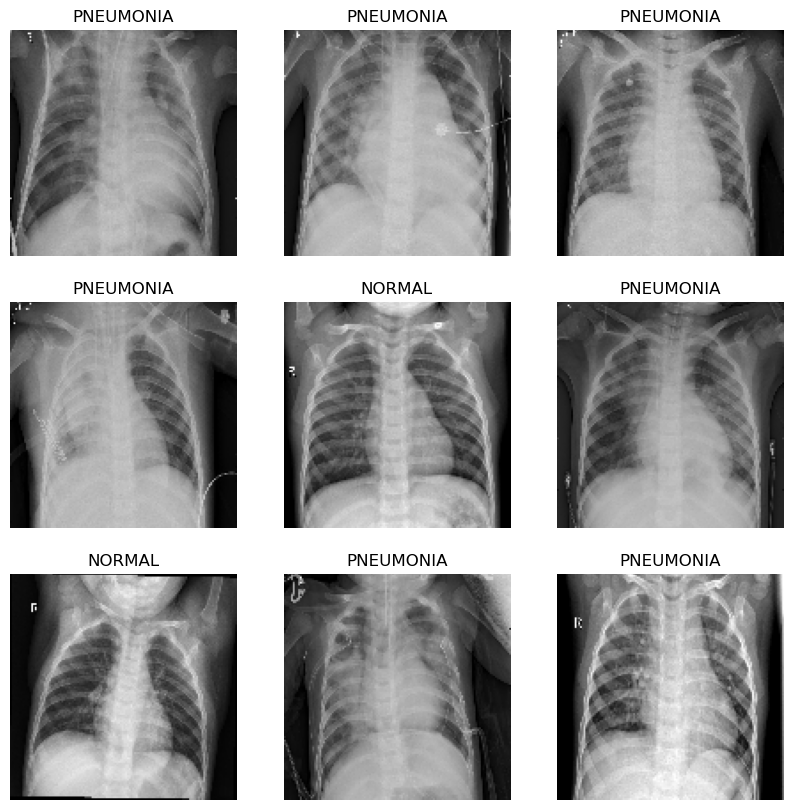

In [5]:

# Display the 9 first x-rays of a selected batch (1st one in this example)
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1): 
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        

In [6]:

# Size of image and label batches
for image_batch, labels_batch in test_data.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)


(32, 128, 128, 3)
(32,)


In [7]:

# An image RGB channel value before standardization
image_batch, labels_batch = next(iter(train_data)) # select first batch
first_image = image_batch[0]
print('Values before standardization:',np.min(first_image), np.max(first_image))


Values before standardization: 0.0 255.0


In [8]:

'''
Let's implement a classic CNN that consists of key layers: 
- Convolutional (extracts features), 
- Activation (introduces non-linearity), 
- Pooling (reduces dimensionality), 
- and Fully Connected (performs classification).
'''
# CNN regular architecture
model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten()) # Because layers are 3D
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        3

In [10]:

# An image RGB channel value after standardization
image_batch, labels_batch = next(iter(train_data)) # select first batch
first_image = image_batch[0]
print('Values after standardization:', np.min(first_image), np.max(first_image))


Values after standardization: 0.0 255.0


In [11]:

epochs = 5

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

history = model.fit(train_data,
                   epochs=epochs,
                   validation_data=test_data)


Epoch 1/5
131/131 [==============================] - 61s 451ms/step - loss: 0.3025 - accuracy: 0.8804 - val_loss: 0.6651 - val_accuracy: 0.7742
Epoch 2/5
131/131 [==============================] - 51s 383ms/step - loss: 0.1076 - accuracy: 0.9590 - val_loss: 0.6070 - val_accuracy: 0.7742
Epoch 3/5
131/131 [==============================] - 49s 367ms/step - loss: 0.1083 - accuracy: 0.9609 - val_loss: 1.1489 - val_accuracy: 0.7016
Epoch 4/5
131/131 [==============================] - 47s 354ms/step - loss: 0.0783 - accuracy: 0.9729 - val_loss: 1.2596 - val_accuracy: 0.7419
Epoch 5/5
131/131 [==============================] - 47s 354ms/step - loss: 0.0559 - accuracy: 0.9801 - val_loss: 1.7570 - val_accuracy: 0.6774


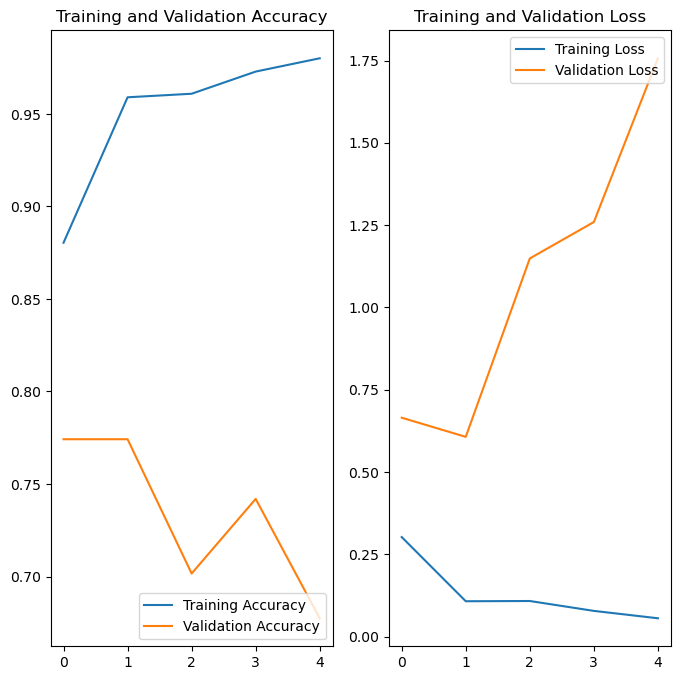

In [12]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [13]:
'''
The plot above shows increasing performance on training set, while performance on validation test is decreasing.
We are probably facing and overfitting issue.

A workaround would be to use data augmentation in order to:
- rebalance classes proportions
- increase number of training images

Another solution would be to add dropout layers to our model.
'''

'\nThe plot above shows increasing performance on training set, while performance on validation test is decreasing.\nWe are probably facing and overfitting issue.\n\nA workaround would be to use data augmentation in order to:\n- rebalance classes proportions\n- increase number of training images\n\nAnother solution would be to add dropout layers to our model.\n'

In [14]:

# Data Augmentation
data_augmentation = models.Sequential()
data_augmentation.add(layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3))),
data_augmentation.add(layers.RandomRotation(0.1)),
data_augmentation.add(layers.RandomZoom(0.1)),
data_augmentation.add(layers.RandomBrightness(0.2))
                      

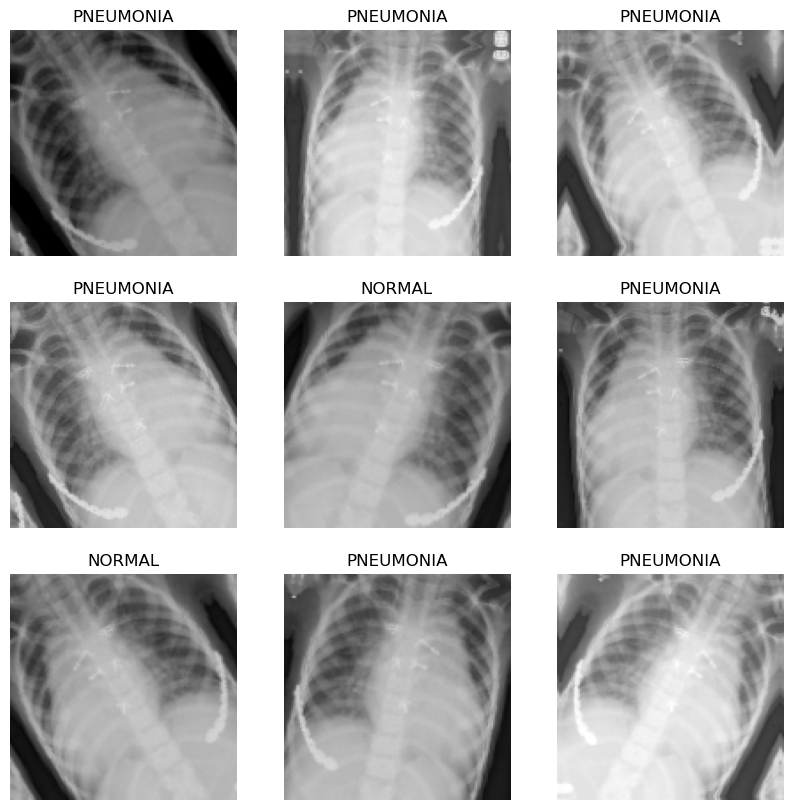

In [15]:

plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1): 
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        

In [19]:

model = models.Sequential()
model.add(data_augmentation)
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))
          

In [20]:

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                  

In [21]:

epochs = 10

history = model.fit(train_data,
                   epochs=epochs,
                   validation_data=test_data)


Epoch 1/10
131/131 [==============================] - 56s 396ms/step - loss: 0.5995 - accuracy: 0.7318 - val_loss: 0.6513 - val_accuracy: 0.6210
Epoch 2/10
131/131 [==============================] - 59s 445ms/step - loss: 0.4169 - accuracy: 0.7664 - val_loss: 0.5447 - val_accuracy: 0.7419
Epoch 3/10
131/131 [==============================] - 58s 435ms/step - loss: 0.3444 - accuracy: 0.8730 - val_loss: 0.5719 - val_accuracy: 0.8065
Epoch 4/10
131/131 [==============================] - 59s 447ms/step - loss: 0.3323 - accuracy: 0.8728 - val_loss: 0.5994 - val_accuracy: 0.8065
Epoch 5/10
131/131 [==============================] - 59s 444ms/step - loss: 0.3206 - accuracy: 0.8771 - val_loss: 0.6113 - val_accuracy: 0.7581
Epoch 6/10
131/131 [==============================] - 63s 472ms/step - loss: 0.3131 - accuracy: 0.8811 - val_loss: 0.5108 - val_accuracy: 0.8145
Epoch 7/10
131/131 [==============================] - 58s 440ms/step - loss: 0.3002 - accuracy: 0.8778 - val_loss: 0.5721 - val_ac

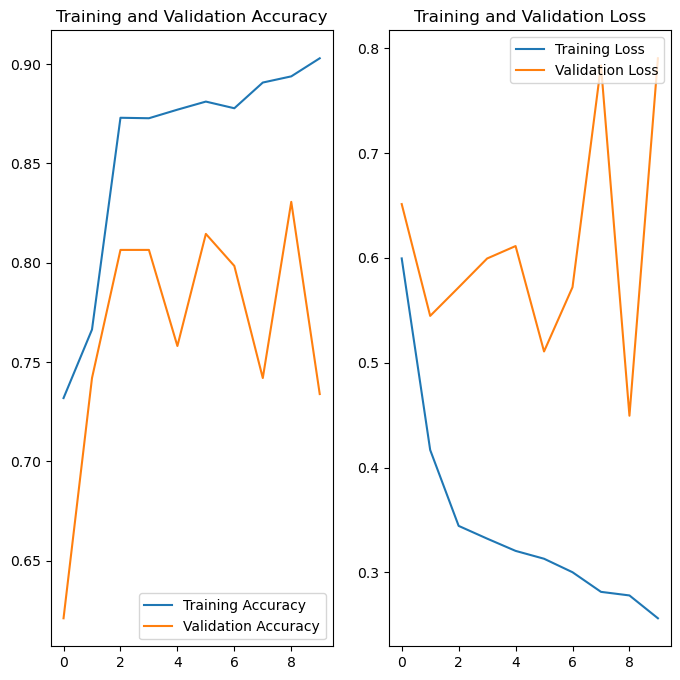

In [22]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
print(f"Mean accuracy on training data : {np.mean(acc)}")
print(f"Mean accuracy on validation data : {np.mean(val_acc)}")
print(f"Mean loss on training data : {np.mean(loss)}")
print(f"Mean loss on validation data : {np.mean(val_loss)}")

Mean accuracy on training data : 0.8567457497119904
Mean accuracy on validation data : 0.7653225839138031
Mean loss on training data : 0.34430551528930664
Mean loss on validation data : 0.6085133820772171


In [16]:
# Lenet, efficientnet Architecture

In [17]:
# Avec Pytorch